# Setup

In [7]:
%load_ext autoreload
%autoreload 2
import tool_kit as tk
import numpy as np
import pandas as pd

In [51]:
images = tk.load_data_image()
mask = tk.load_data_mask()
images.head()

,image_id,nb_cells
0,SIMCEPImages_A13_C53_F1_s09_w2.TIF,53
1,SIMCEPImages_A03_C10_F1_s20_w1.TIF,10
2,SIMCEPImages_A01_C1_F1_s07_w2.TIF,1
3,SIMCEPImages_A16_C66_F1_s06_w1.TIF,66
4,SIMCEPImages_A20_C83_F1_s07_w2.TIF,83


## Separation test set et train set

In [90]:
import numpy as np
import pandas as pd

unseen = images[images['mask'] == 'no']
df_image_mask  = images[images['mask'] == 'yes']
df_test_set = df_image_mask.sample(frac=0.2, random_state=42)
df_train_set = df_image_mask.drop(df_test_set.index)
df_train_set.drop('mask', axis=1, inplace=True)
df_test_set.drop('mask', axis=1, inplace=True)
len(df_test_set), len(df_train_set)

(240, 960)

## Test d'affichage d'une image

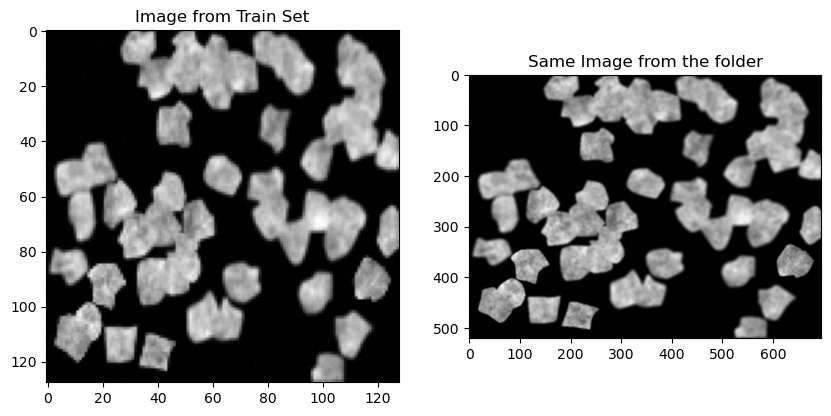

In [101]:
import cv2
IMG_HEIGHT = 128
IMG_WIDTH = 128


folder = 'dataset/archive/BBBC005_v1_images/BBBC005_v1_images'
test_image = cv2.imread(folder + '/' + df_train_set["image_id"].iloc[0], cv2.IMREAD_GRAYSCALE)


import matplotlib.pyplot as plt
x_train = tk.data_to_matrix(df_train_set,IMG_WIDTH,IMG_HEIGHT,'image')
x_test = tk.data_to_matrix(df_test_set,IMG_WIDTH,IMG_HEIGHT,'image')
y_train = tk.data_to_matrix(df_train_set,IMG_WIDTH,IMG_HEIGHT,'mask')
y_test = tk.data_to_matrix(df_test_set,IMG_WIDTH,IMG_HEIGHT,'mask')
fig , axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].imshow(x_train[0], cmap='gray')
axes[0].set_title("Image from Train Set")  # Adding a title

axes[1].imshow(test_image, cmap='gray')
axes[1].set_title("Same Image from the folder")  # Adding a title
plt.show()

## Affichage image et mask correspondant

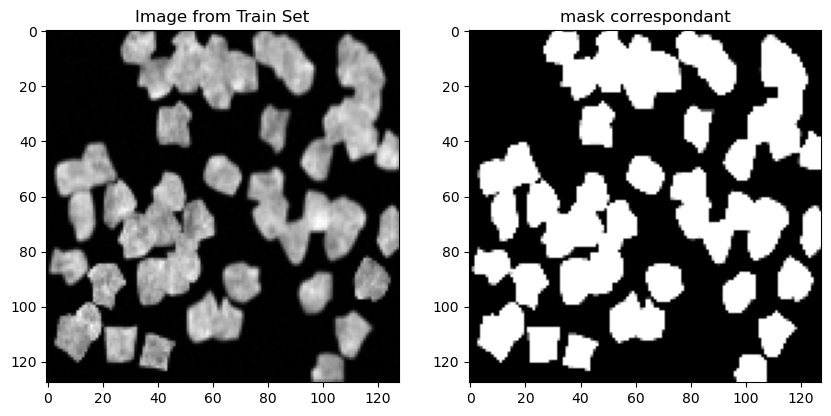

In [54]:
fig , axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].imshow(x_train[0], cmap='gray')
axes[0].set_title("Image from Train Set")  # Adding a title
axes[1].imshow(y_train[0], cmap='gray')
axes[1].set_title("mask correspondant")  # Adding a title
plt.show()

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dropout = 0.2
nb_filtre = 16


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.conv_block(1, nb_filtre)   # 1 canal pour l'image greyscale
        self.enc_conv2 = self.conv_block(nb_filtre*(2**0), nb_filtre*(2**1))
        self.enc_conv3 = self.conv_block(nb_filtre*(2**1), nb_filtre*(2**2))
        self.enc_conv4 = self.conv_block(nb_filtre*(2**2), nb_filtre*(2**3))
        
        # Bottleneck
        self.bottleneck = self.conv_block(nb_filtre*(2**3), nb_filtre*(2**4))
        
        # Decoder
        self.dec_conv4 = self.conv_block(nb_filtre*(2**4) + nb_filtre*(2**3), nb_filtre*(2**3))  # Skip connections
        self.dec_conv3 = self.conv_block(nb_filtre*(2**3) + nb_filtre*(2**2), nb_filtre*(2**2))
        self.dec_conv2 = self.conv_block(nb_filtre*(2**2) + nb_filtre*(2**1), nb_filtre*(2**1))
        self.dec_conv1 = self.conv_block(nb_filtre*(2**1) + nb_filtre, nb_filtre)
        
        # Final Convolution
        self.final_conv = nn.Conv2d(nb_filtre, 1, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        """
        Block de convolution : Conv2d -> ReLU -> Dropout -> Conv2d -> ReLU -> Dropout
        """
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),  # Dropout après chaque couche de convolution
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        return block
    
    def forward(self, x):
        # Encoder path
        enc1 = self.enc_conv1(x)  # [B, 32, 128, 128]
        enc2 = self.enc_conv2(F.max_pool2d(enc1, 2))  # [B, 64, 64, 64]
        enc3 = self.enc_conv3(F.max_pool2d(enc2, 2))  # [B, 128, 32, 32]
        enc4 = self.enc_conv4(F.max_pool2d(enc3, 2))  # [B, 256, 16, 16]
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))  # [B, 512, 8, 8]
        
        # Decoder path
        dec4 = self.up_concat(bottleneck, enc4)  # [B, 512, 16, 16]
        dec4 = self.dec_conv4(dec4)  # [B, 256, 16, 16]
        
        dec3 = self.up_concat(dec4, enc3)  # [B, 256, 32, 32]
        dec3 = self.dec_conv3(dec3)  # [B, 128, 32, 32]
        
        dec2 = self.up_concat(dec3, enc2)  # [B, 128, 64, 64]
        dec2 = self.dec_conv2(dec2)  # [B, 64, 64, 64]
        
        dec1 = self.up_concat(dec2, enc1)  # [B, 64, 128, 128]
        dec1 = self.dec_conv1(dec1)  # [B, 32, 128, 128]
        
        # Final layer
        output = torch.sigmoid(self.final_conv(dec1))  # [B, 1, 128, 128]
        # output = (output >= 0.5).float()  # Thresholding at 0.5 to get 0 or 1
        return output
    
    def up_concat(self, x1, x2):
        """
        Fonction pour le chemin de décodage (concaténation avec skip connections)
        """
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=True)
        return torch.cat([x1, x2], dim=1)

# Initialiser le modèle
model = UNet()


# Summary of the model
from torchsummary import summary
summary(model, input_size=(1, 128, 128))  # Input size is (1, 128, 128) for grayscale images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
           Dropout-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
              ReLU-5         [-1, 16, 128, 128]               0
           Dropout-6         [-1, 16, 128, 128]               0
            Conv2d-7           [-1, 32, 64, 64]           4,640
              ReLU-8           [-1, 32, 64, 64]               0
           Dropout-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           9,248
             ReLU-11           [-1, 32, 64, 64]               0
          Dropout-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]          18,496
             ReLU-14           [-1, 64,

In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

## convertit les données pour pytorch

In [102]:
x_train = torch.tensor(x_train).float().unsqueeze(1).unsqueeze(1)
x_test = torch.tensor(x_test).float().unsqueeze(1).unsqueeze(1)
y_train = torch.tensor(y_train).float().unsqueeze(1).unsqueeze(1)
y_test = torch.tensor(y_test).float().unsqueeze(1).unsqueeze(1)


#normalisation de du mask pour avoir des valeurs entre 0 et 1
x_train = x_train/255
x_test = x_test/255
y_train = y_train/255
y_test = y_test/255

In [103]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in zip(x_train, y_train):
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss

      # validate the model
      model.eval()
      for data, label in zip(x_test,y_test):
        with torch.no_grad():
            output = model(data)
        loss = criterion(output,label)
        valid_loss += loss.item() * data.size(0)

      # calculate average loss over an epoch
      train_loss /= len(x_train)
      valid_loss /= len(x_test)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [104]:
train_losses, valid_losses = training(n_epochs, x_train, y_train, model, criterion, optimizer)

epoch: 1 	training Loss: 0.059287 	validation Loss: 0.021003
validation loss decreased (inf --> 0.021003).  Saving model ...
epoch: 2 	training Loss: 0.023697 	validation Loss: 0.017762
validation loss decreased (0.021003 --> 0.017762).  Saving model ...
epoch: 3 	training Loss: 0.020879 	validation Loss: 0.016187
validation loss decreased (0.017762 --> 0.016187).  Saving model ...
epoch: 4 	training Loss: 0.019440 	validation Loss: 0.015396
validation loss decreased (0.016187 --> 0.015396).  Saving model ...
epoch: 5 	training Loss: 0.018484 	validation Loss: 0.014947
validation loss decreased (0.015396 --> 0.014947).  Saving model ...
epoch: 6 	training Loss: 0.017697 	validation Loss: 0.014546
validation loss decreased (0.014947 --> 0.014546).  Saving model ...
epoch: 7 	training Loss: 0.017088 	validation Loss: 0.014046
validation loss decreased (0.014546 --> 0.014046).  Saving model ...
epoch: 8 	training Loss: 0.016627 	validation Loss: 0.013952
validation loss decreased (0.01404

## Image et mask correspondant généré avec u-net

/var/folders/rw/pr8ypc3j0fq4c3b12n99pdp00000gn/T/ipykernel_45811/3900566598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('u_net.pt'))

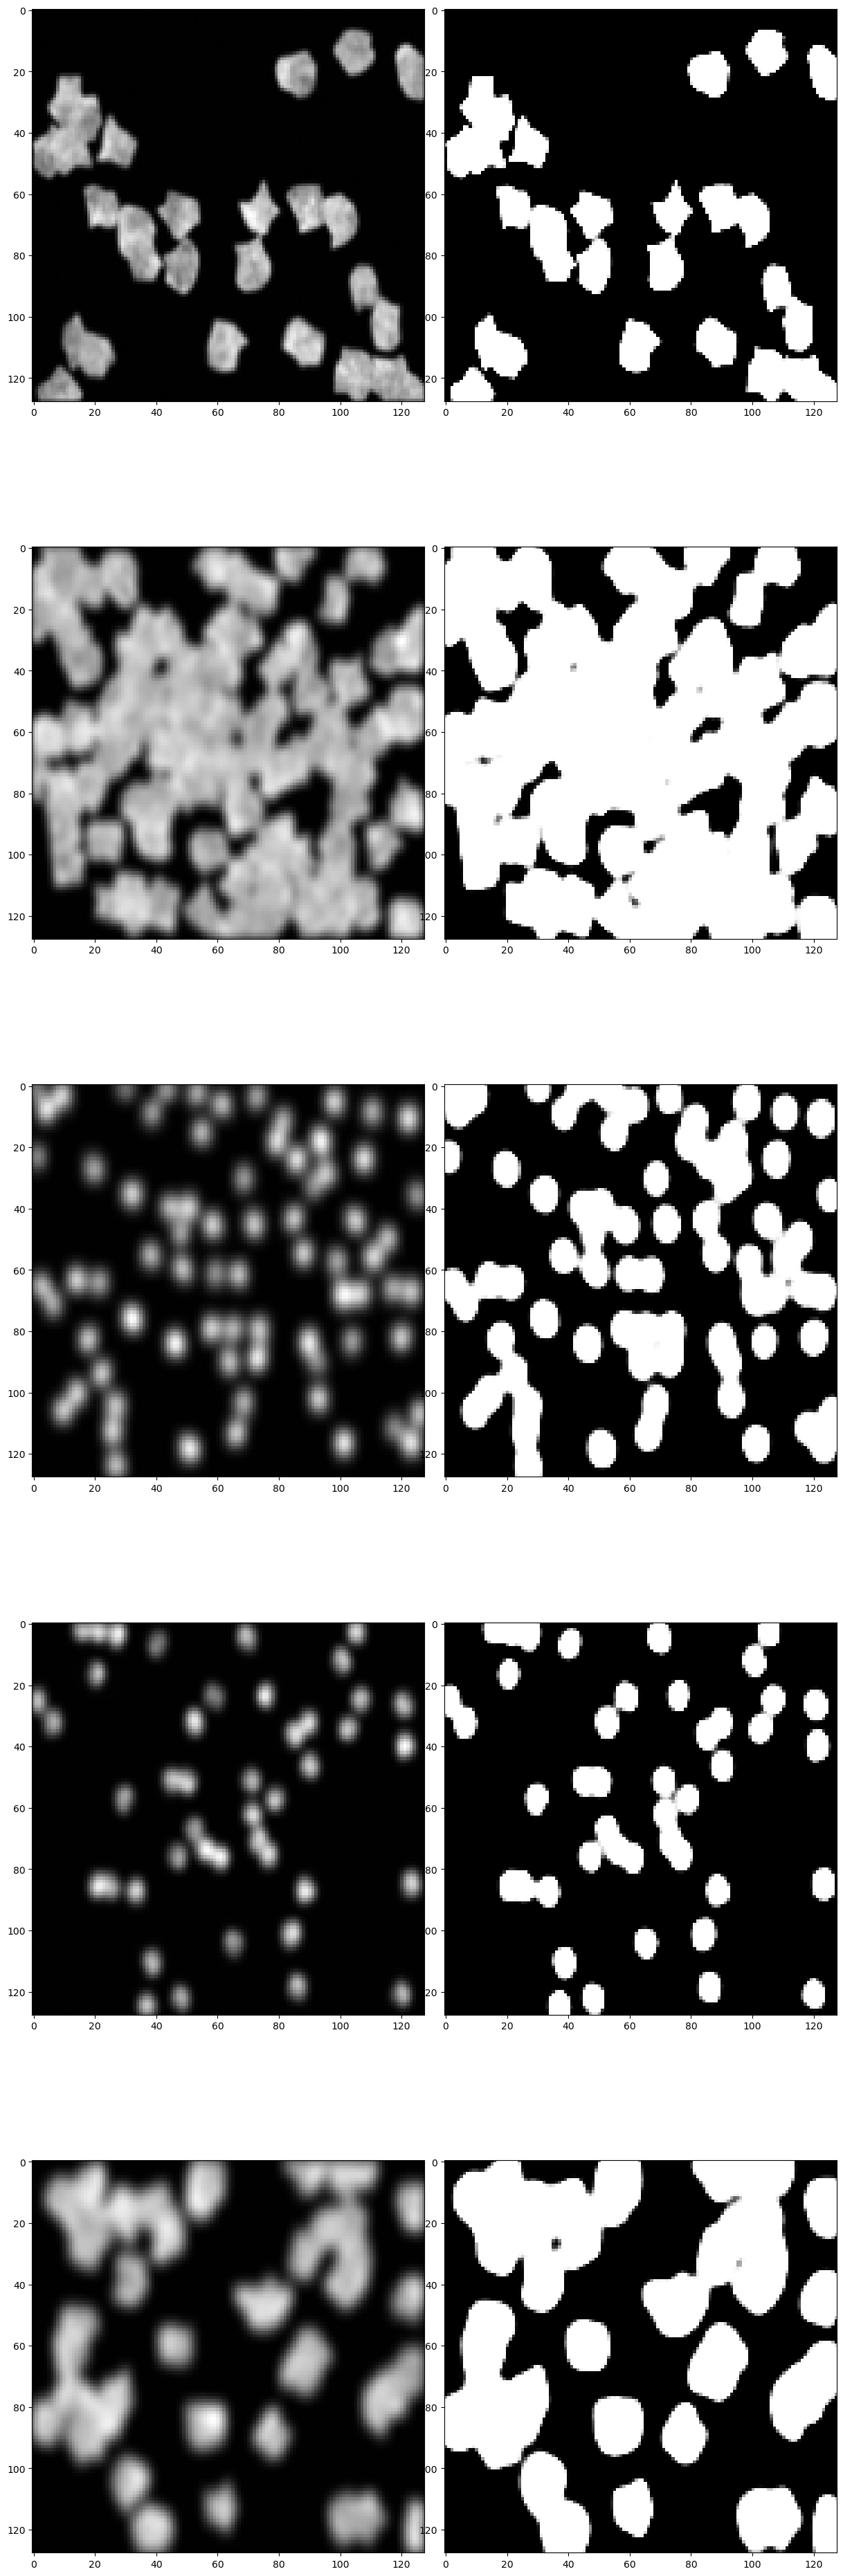

In [132]:
model.load_state_dict(torch.load('u_net.pt'))
unseen = unseen.iloc[:5]
x_unseen = tk.data_to_matrix(unseen,IMG_WIDTH,IMG_HEIGHT,'image')
x_unseen
y_unseen = [model(torch.tensor(image).float().unsqueeze(0).unsqueeze(0)/255).detach().numpy()*255 for image in x_unseen]
y_unseen = np.round(y_unseen)

fig , axes = plt.subplots(5,2 , figsize=(15,50))
for i in range(5):
    axes[i,0].imshow(x_unseen[i], cmap='gray')
    axes[i,1].imshow(y_unseen[i][0][0], cmap='gray')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()